## %matplotlib  inline 
import pandas as pd
import numpy as np
import scipy.stats as sas
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib as mpl  
mpl.rc('figure', figsize=(10, 7.5))
font = {'family' : 'monospace',
          'weight' : 'bold',
          'size'   : 30.2}
mpl.rc("font",**font)
mpl.rc('lines', lw=2, c='r')

In [6]:
call_record_hour=pd.read_csv("data/call_record_hour.csv",index_col=0)

In [7]:
cust_user_info=pd.read_csv("data/fdl_cust_user_info_chain.csv",index_col=1)
cust_user_info.drop(['Unnamed: 0'],inplace=True,axis=1)
cust_user_info=cust_user_info.drop_duplicates(subset=["id_no"])

/usr/bin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
call_record_hour.head(6)

,custorm_id,name,number,call_time,type,time,contact_gap
0,4335793,赖立新,13001011021,2016-11-04 10:17:24,2,22.0,NaN
1,3157627,13001016170,13001016170,2016-11-30 08:08:13,2,0.0,NaN
2,2559110,8613001018225,13001018225,2016-06-30 10:32:02,2,NaN,0.000313
2,2559110,8613001018225,13001018225,2016-06-30 10:32:29,2,NaN,0.000313
2,2559110,8613001018225,13001018225,2016-06-30 10:33:13,2,NaN,0.000509
2,2559110,8613001018225,13001018225,2016-06-30 10:33:38,2,NaN,0.000289


In [9]:
cust_user_info.head(6)

,cust_name,id_no,mobi_no,reg_src
id,,,,
5798,戴俊安,371311198712212615,18267179687,Android
20995,肖艳平,430204197010230028,18607337862,Android
25064,申俊鹤,410526199107059570,13253382545,Android
40794,庄超,350627198804100058,15259663858,Android
49569,李小峰,150221199302253254,15049339225,Android
61893,王笑娓,652322199304170024,18690211580,iOS


## 数据清理
- time=="nan":(25799780, 7)
- 去除 time=="nan" 和 通话时间小于11.5s 的记录
- 数据清理后27242414条

In [10]:
call_record_hour=call_record_hour[(call_record_hour.time.apply(str)!='nan')&(call_record_hour.time>11.5)]

In [11]:
call_record_hour.shape

(27242414, 7)

In [12]:
call_record_hour.set_index("custorm_id",inplace=True)
call_record_hour=call_record_hour.join(cust_user_info)

cust_user_info.rename_axis({"mobi_no":"number"},axis="columns",inplace=True)

call_record_hour=pd.merge(call_record_hour,cust_user_info,on="number",how="inner",right_index=True,suffixes=("_A","_B"))


In [13]:
## 出生年
call_record_hour["age_A"]=call_record_hour.id_no_A.str.slice(6,10).astype("float")
call_record_hour["age"]=call_record_hour.id_no_B.str.slice(6,10).astype("float")
call_record_hour["age_Gap"]=call_record_hour.age-call_record_hour.age_A
##出生月
call_record_hour["born_month"]=call_record_hour.id_no_B.str.slice(10,12).astype("float")
call_record_hour["born_month_A"]=call_record_hour.id_no_A.str.slice(10,12).astype("float")
## 性别
call_record_hour["sex_A"]=call_record_hour.id_no_A.str.slice(16,17)
call_record_hour["sex"]=call_record_hour.id_no_B.str.slice(16,17)

##省份
call_record_hour["id_province"]=call_record_hour.id_no_B.str.slice(0,2)
call_record_hour["id_province_A"]=call_record_hour.id_no_A.str.slice(0,2)
call_record_hour["same_province"]=call_record_hour.id_province==call_record_hour.id_province_A
## 城市
call_record_hour["id_city"]=call_record_hour.id_no_B.str.slice(2,4)
call_record_hour["id_city_A"]=call_record_hour.id_no_A.str.slice(2,4)
call_record_hour["same_city"]=call_record_hour.id_city==call_record_hour.id_city_A

In [14]:
call_record_hour.drop_duplicates(inplace=True)

In [15]:
call_record_hour.columns

Index([u'name', u'number', u'call_time', u'type', u'time', u'contact_gap',
       u'cust_name_A', u'id_no_A', u'mobi_no', u'reg_src_A', u'cust_name_B',
       u'id_no_B', u'reg_src_B', u'age_A', u'age', u'age_Gap', u'born_month',
       u'born_month_A', u'sex_A', u'sex', u'id_province', u'id_province_A',
       u'same_province', u'id_city', u'id_city_A', u'same_city'],
      dtype='object')

In [16]:
call_record_hour=call_record_hour[call_record_hour.time<3600.0]


In [17]:
call_record_hour=call_record_hour[call_record_hour.age_A.apply(str)!='nan']

In [18]:
def getPlot(x,y,ylabel):
    sns.jointplot(x,y,xlim=[1960,2000],size=7,ratio=3,stat_func=sas.spearmanr,\
                  marginal_kws=dict(bins=10, rug=True),s=40,
                  annot_kws=dict(stat="r"),edgecolor="w",space=0.05, linewidth=1).set_axis_labels("Year", ylabel)
sns.set( color_codes=True)

##  数据分析

### 1.通话时长分析

In [19]:
def getTimePlot(df):
    time_cnt=df.time.value_counts()
    time_cnt=time_cnt/time_cnt.sum()
    sns.jointplot(time_cnt.index,time_cnt.values,xlim=[0,650],size=8).set_axis_labels("call_duration", "proportion")

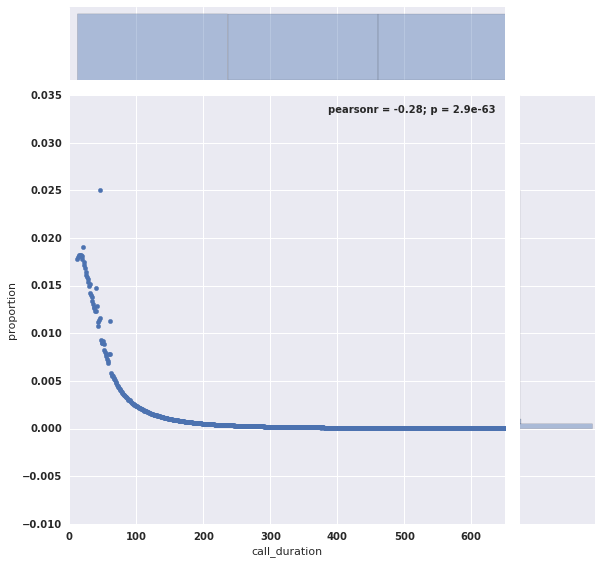

In [20]:
getTimePlot(call_record_hour)

In [21]:
cond=(call_record_hour.age_Gap<60)&(call_record_hour.age_Gap>-60)
ageGap=call_record_hour[cond].age_Gap.value_counts()


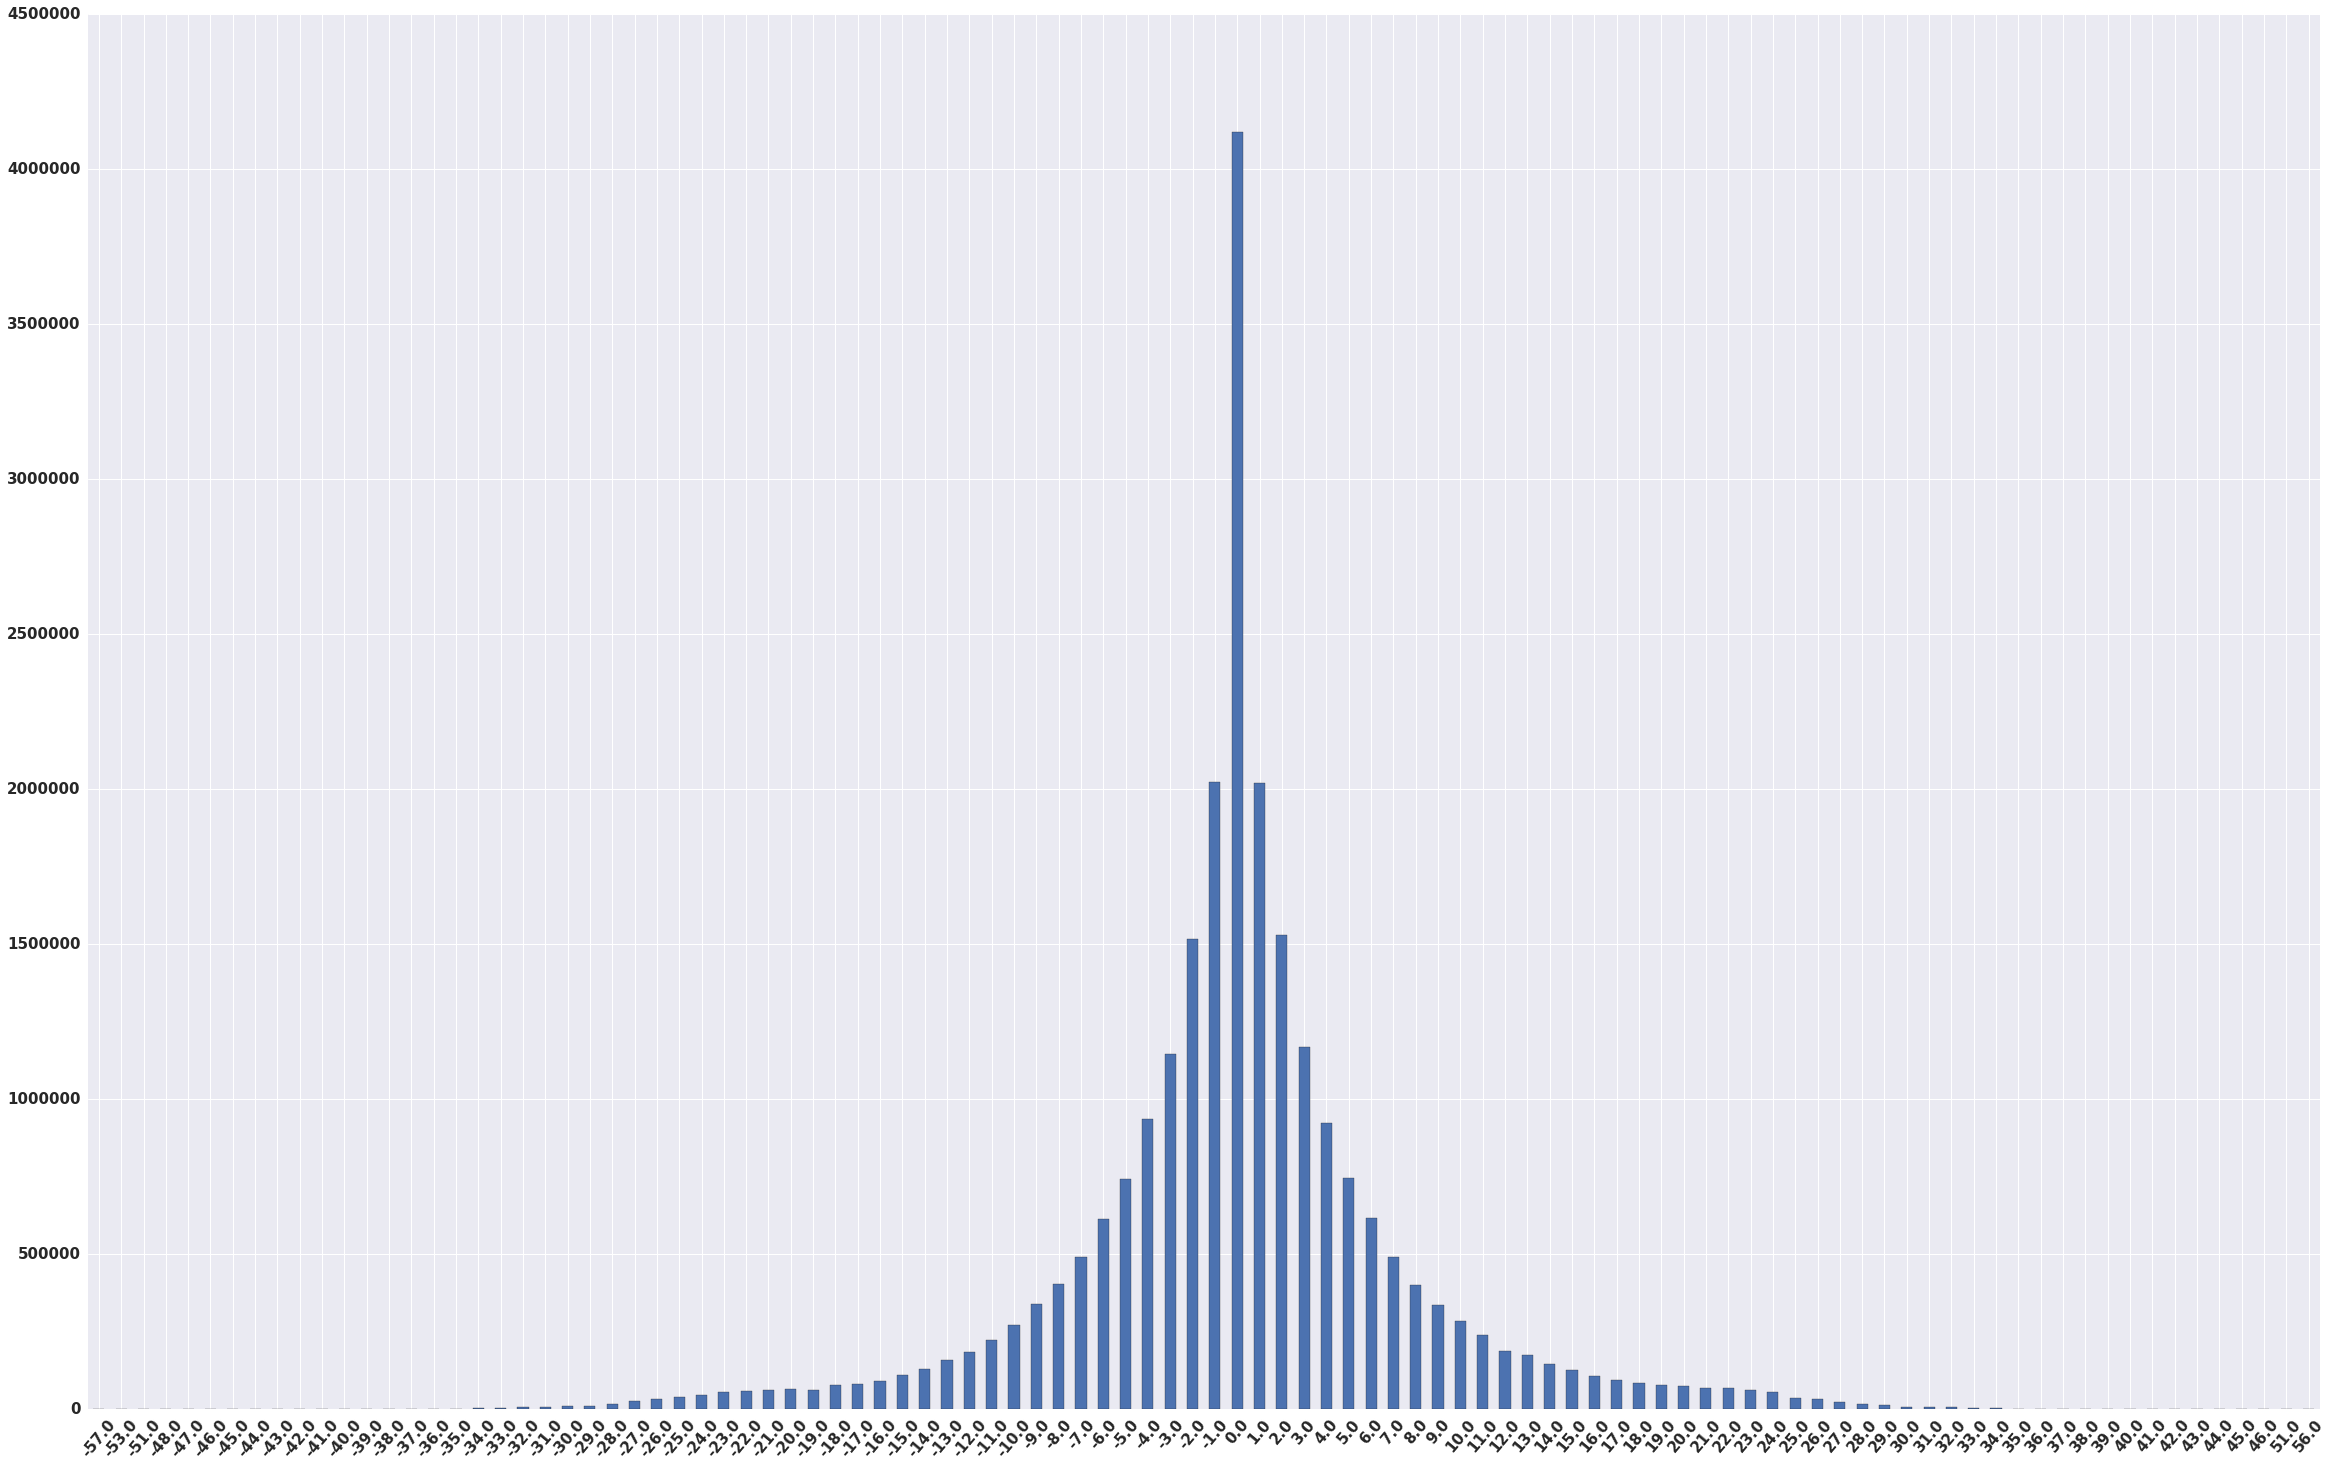

In [22]:
ageGap.sort_index().plot.bar(figsize=[40,25],rot=50,fontsize=15)

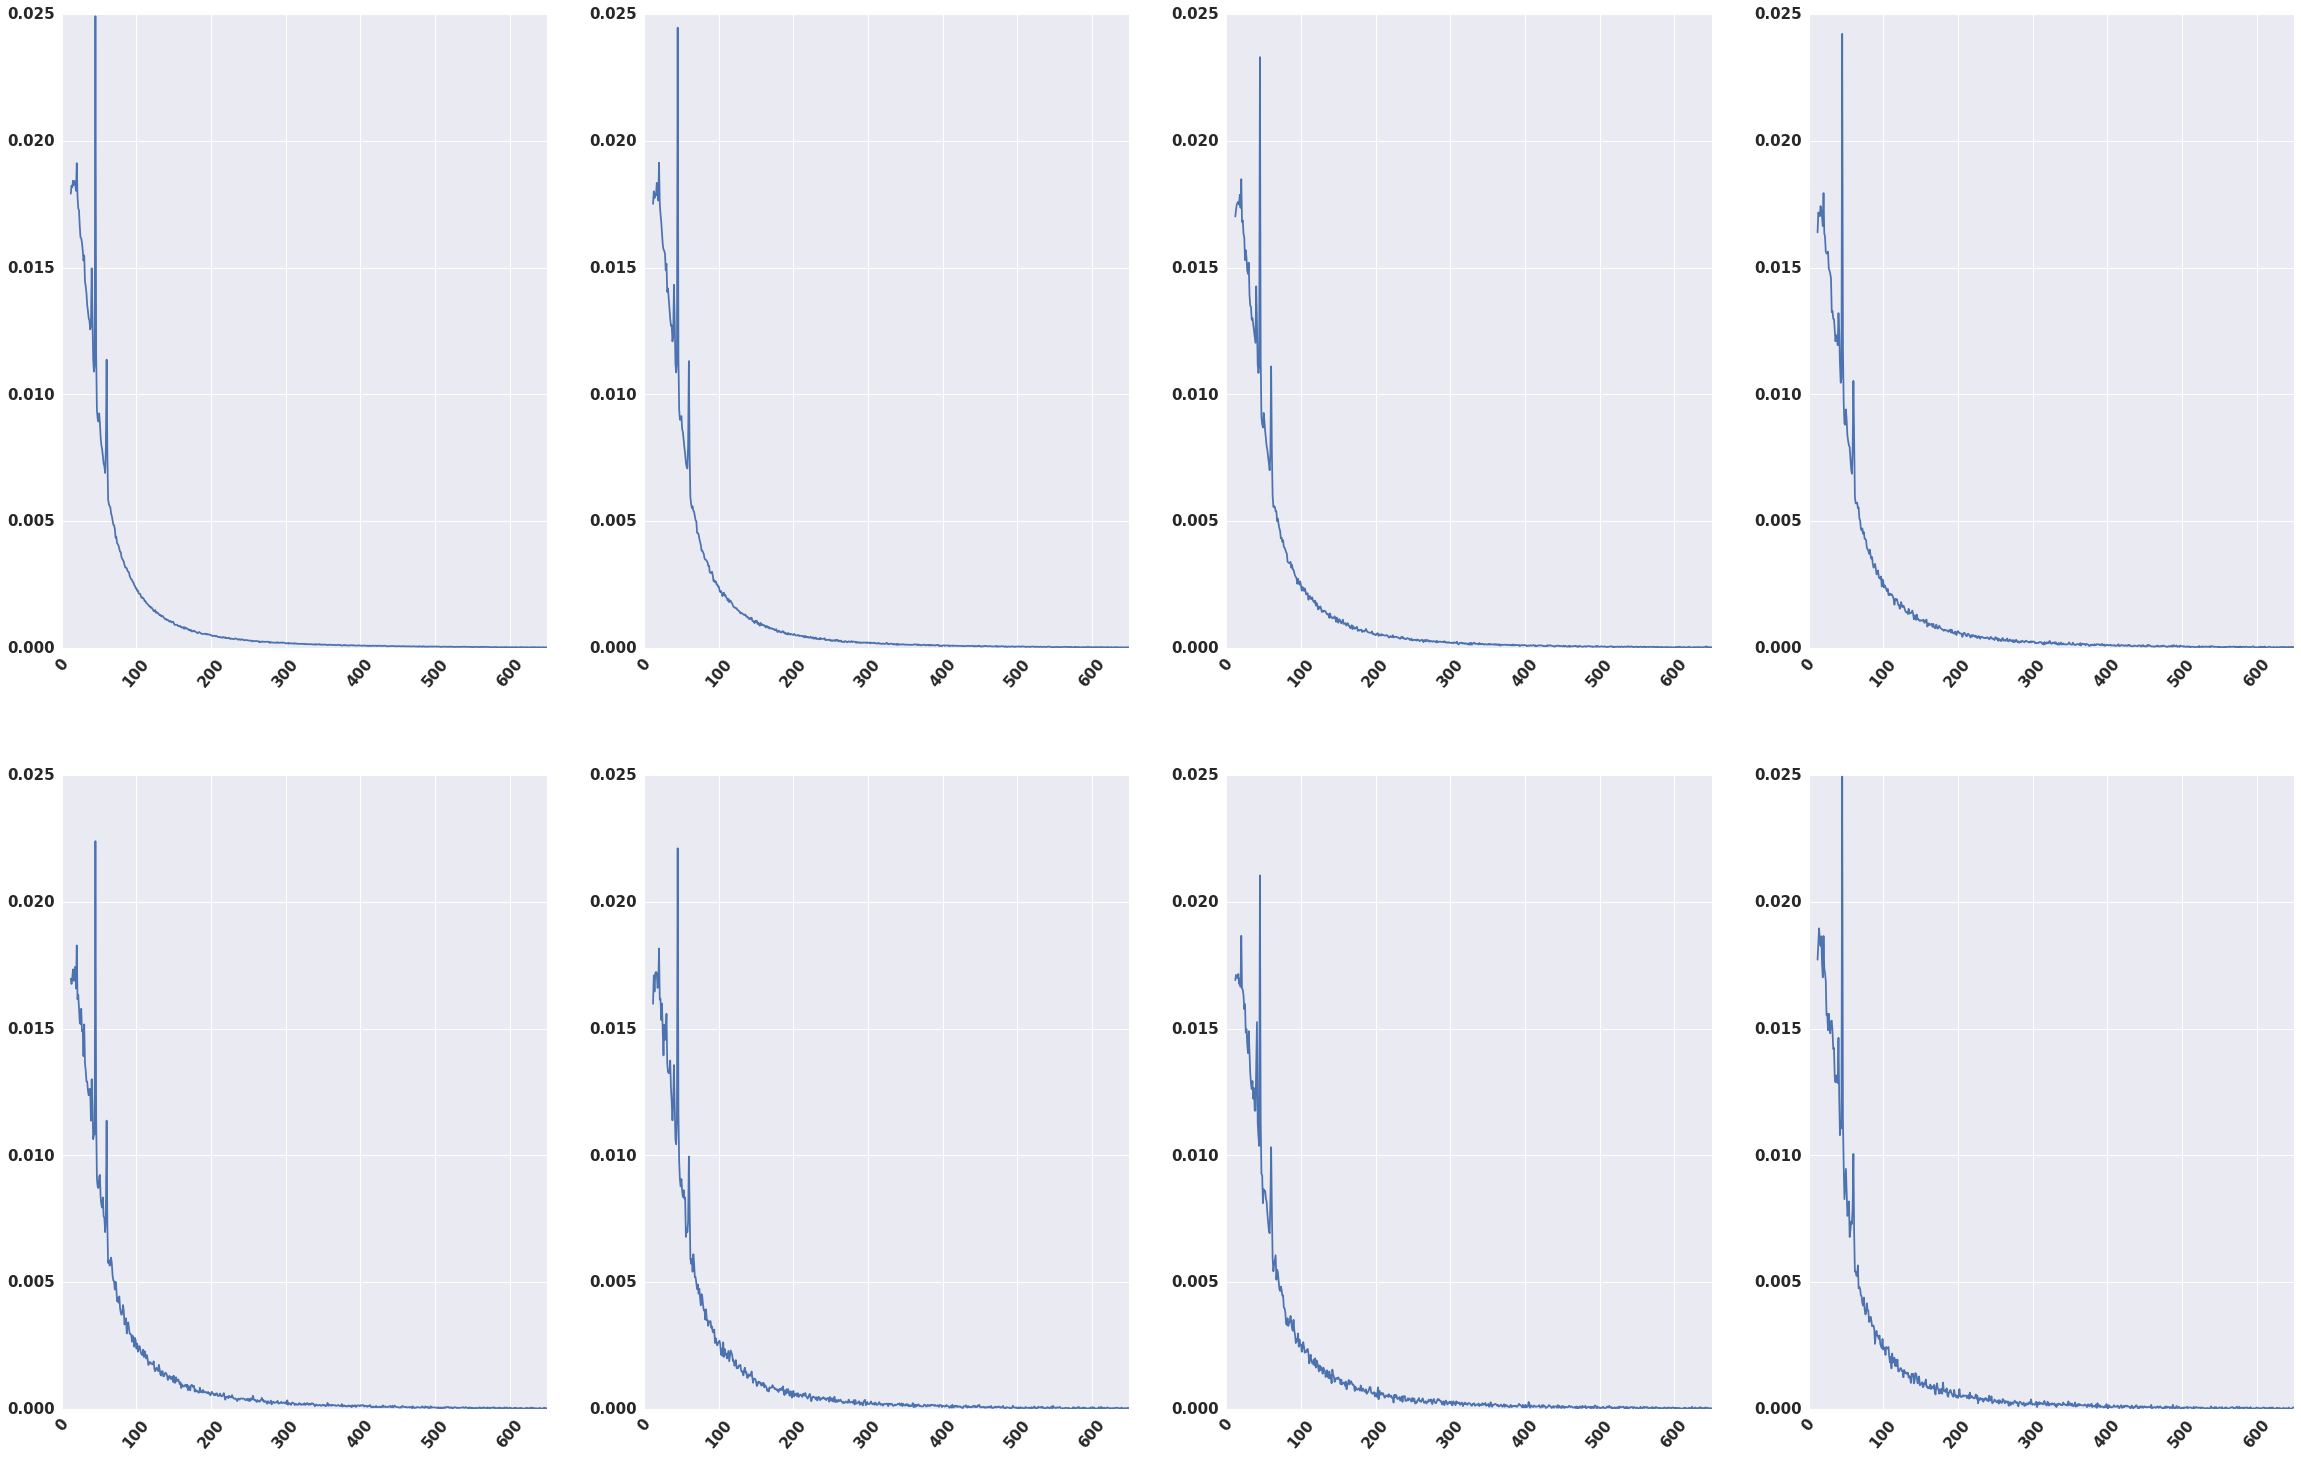

In [45]:
a=241
for GapNum in np.arange(1.0,23,3):
    plt.subplot(a)
    cond_age=call_record_hour.age_Gap==GapNum
    time_cnt=call_record_hour[cond_age].time.value_counts()
    time_cnt=time_cnt/time_cnt.sum()
    time_cnt.sort_index().plot.line(xlim=[0,650],figsize=[40,25],rot=50,fontsize=15)
    a+=1

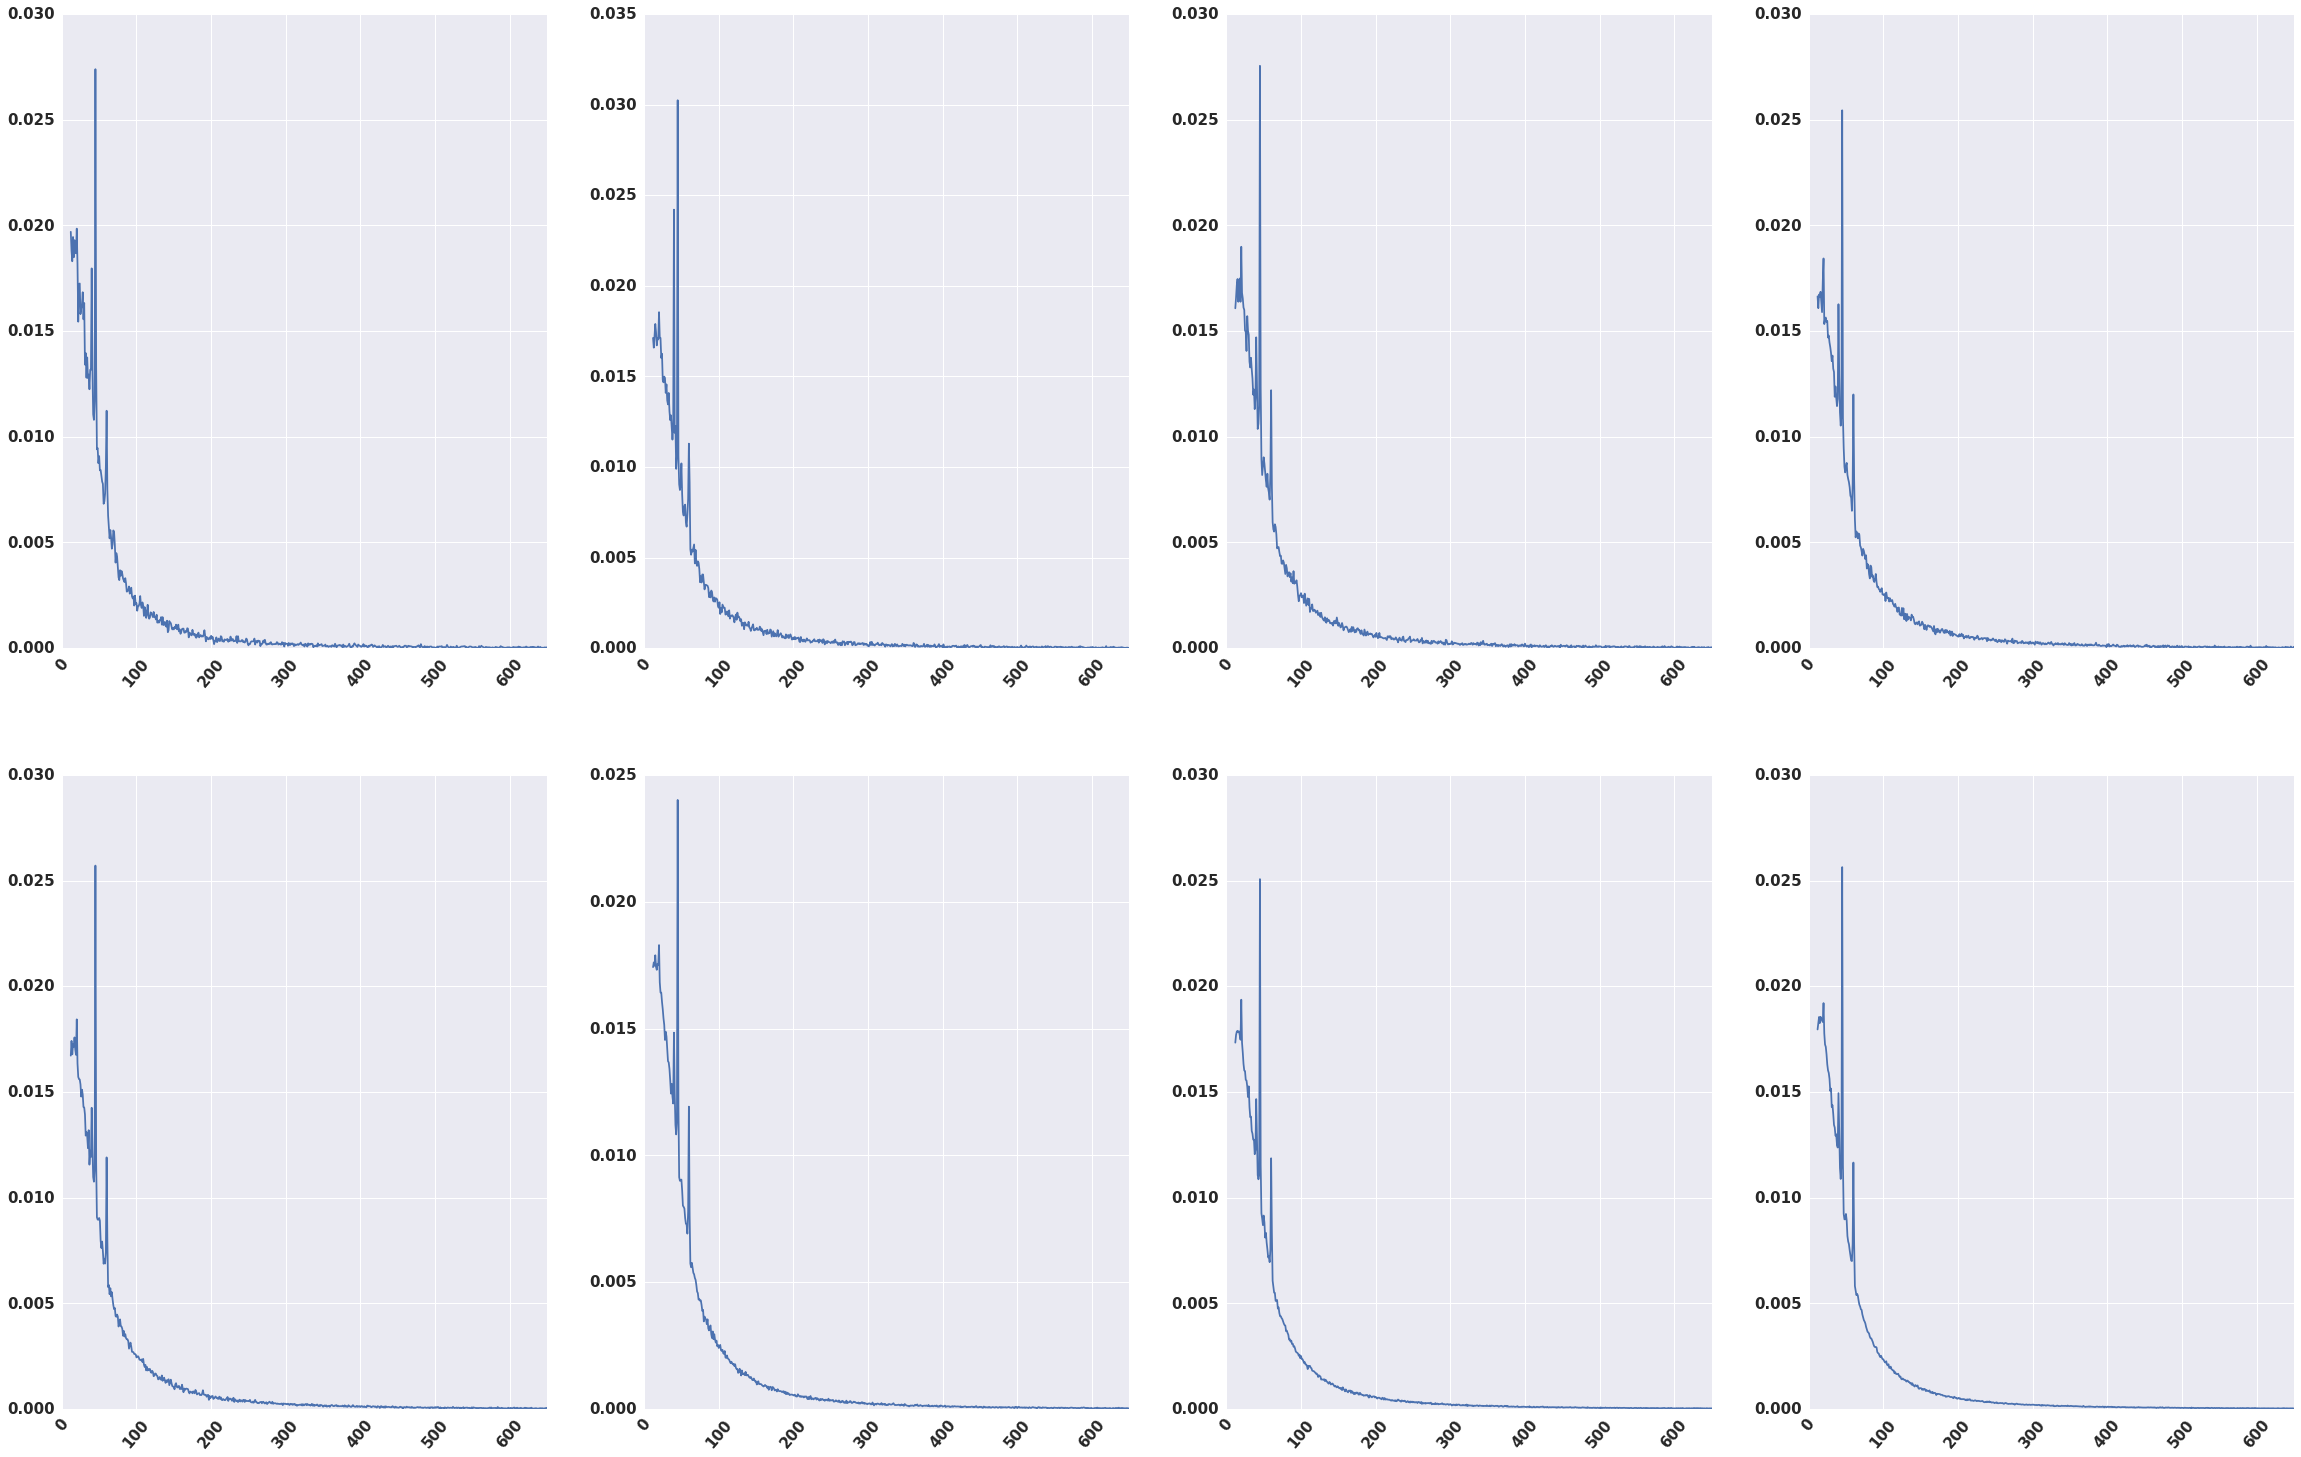

In [46]:
a=241
for GapNum in np.arange(-23.0,1.0,3):
    plt.subplot(a)
    cond_age=call_record_hour.age_Gap==GapNum
    time_cnt=call_record_hour[cond_age].time.value_counts()
    time_cnt=time_cnt/time_cnt.sum()
    time_cnt.sort_index().plot.line(xlim=[0,650],figsize=[40,25],rot=50,fontsize=15)
    a+=1

In [25]:
call_record_hour

NameError: name 'cc' is not defined